In [2]:
import pandas as pd
import numpy as np
import re

file_path = r"C:\Users\DELL\OneDrive\Área de Trabalho\Ironhack\week 2\Week-2-Mini-Project---Shark-Attacks\GSAF5.xls"

df = pd.read_excel(file_path)
print(f"The dataset started with 23 columns and 7045 rows.")

The dataset started with 23 columns and 7045 rows.


In [3]:
# Now we want to clean the dataframe a bit
# First let's have a look at the dataframe
print(df.nunique(), '\n')

Date              6089
Year               261
Type                13
Country            247
State              937
Location          4595
Activity          1606
Name              5770
Sex                 10
Age                250
Injury            4162
Fatal Y/N           12
Time               460
Species           1724
Source            5384
pdf               6789
href formula      6784
href              6776
Case Number       6777
Case Number.1     6775
original order    6797
Unnamed: 21          1
Unnamed: 22          2
dtype: int64 



In [4]:
# Then we want to standardize the column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.columns

Index(['date', 'year', 'type', 'country', 'state', 'location', 'activity',
       'name', 'sex', 'age', 'injury', 'fatal_y/n', 'time', 'species',
       'source', 'pdf', 'href_formula', 'href', 'case_number', 'case_number.1',
       'original_order', 'unnamed:_21', 'unnamed:_22'],
      dtype='object')

In [5]:
df["country"] = df["country"].str.title()

In [6]:
df = df.drop_duplicates(subset=["country"])
df["country"].nunique()

220

In [7]:
# We can see that there are some weird values in the 'type' column such as 'Boat', 'Questionable ', 'Unconfirmed'
# We want to merge these values into a single category called 'Under investigation'

# First, we drop the rows where 'Type' and 'Sex' are null
df.dropna(subset=["sex", "type"], inplace=True)

# Then, we replace the values in the 'Type' column
def replace_type(value):
    if isinstance(value, str):
        # Remove white spaces and compare lower-case
        value_clean = value.strip().lower()
        valid_types = ['unprovoked', 'provoked']
        if value_clean not in valid_types:
            return "Under investigation"
        else:
            # Return the standardized value (capitalize first letter)
            return value_clean.capitalize()
    return value

df["type"] = df["type"].apply(replace_type)

# Now we can check the value counts again
print(df["type"].value_counts(), '\n')

# Now we want to clean the 'sex' column in the same way
def replace_sex(value):
    if isinstance(value, str):
        if value[0].lower() == "f":
            return "F"
        else:
            return "M"

df["sex"] = df["sex"].apply(replace_sex)
print(df["sex"].value_counts(), '\n')
print(df['sex'].unique(), '\n')

# Now lets dive into the 'time' column and clean it
# We want to have four unique values with the following criteria:
# 6 am until noon -> Morning
# Noon until 6 pm -> Afternoon
# 6 pm until midnight -> Night
# Midnight until 6 am -> Dawn

df['time'].unique()
#df['time'].value_counts()


# We need to use regex to extract the hour and minutes from the 'time' column
# We will create a function to clean the 'time' column
def time_cleaner(val):
    if pd.isna(val):
        return np.nan # Return NaN for null values
    
    val = str(val).strip().lower() # Convert to string and lower case
    
    # Remove unwanted characters
    val = re.sub(r'[^0-9a-z: ]', '', val) # Keep only alphanumeric characters, colon, and space

    # The previous regex cleans the column to keep only the essential characters needed for time parsing
    # The ^ inside []indicates negation, means "match everything EXCEPT these characters", so we basically removing unwanted punctuation, uppercase letters, and special characters while preserving the useful parts

    # Simple textual cases using any() for efficiency
    if any(word in val for word in ['dawn', 'daybreak', 'sunrise', 'early morning']):
        return 'Dawn'
    if any(word in val for word in ['morning']):
        return 'Morning'
    if any(word in val for word in ['noon', 'midday', 'afternoon', 'after noon', 'mid afternoon', 'late afternoon']):
        return 'Afternoon'
    if any(word in val for word in ['evening', 'dusk', 'sunset', 'night', 'dark']):
        return 'Evening'

    # Numeric time formats using regex to capture hour and optional minutes with or without separators
    # This regex is designed to extract time information from various formats
    match = re.search(r'(\d{1,2})[:h]?(\d{0,2})?', val)
    if match:
        hour = int(match.group(1)) # Extract hour from regex group 1
        minutes = match.group(2) if match.group(2) else '00' # Extract minutes from regex group 2 if available

        # 4 digits format without separator (ex: 1530)
        if len(val) >= 4 and val[:4].isdigit(): # Check if first 4 characters are digits
            hour = int(val[:2]) # First two digits are hour
            minutes = val[2:4] # Last two digits are minutes

        # Adjust hour if minutes are superior to 45
        if minutes and minutes.isdigit() and int(minutes) > 45: # If minutes are greater than 45, round up the hour
            hour += 1
        hour = hour % 24  # Ensure hour is within 0-23

        # Convert in 4 periods of the day
        if 5 <= hour < 11:
            return 'Morning'
        elif 11 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 23:
            return 'Evening'
        else:
            return 'Dawn'

    # If nothing matches, return NaN
    return np.nan

# We apply the function to the 'time' column
df['time_clean'] = df['time'].apply(time_cleaner)

# To check the result
print(df['time_clean'].value_counts(dropna=False))

# # Now we want to drop the columns that are not useful for our analysis
df = df.drop(df.columns[[7, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1, inplace=False)
# # We are droping time column because we created a new column 'time_clean' with the cleaned values
# # We did drop the name column because of the data privacy policy in some countries
df.head()

type
Unprovoked             144
Under investigation     35
Provoked                20
Name: count, dtype: int64 

sex
M    169
F     30
Name: count, dtype: int64 

['M' 'F'] 

time_clean
NaN          129
Afternoon     40
Morning       19
Evening        8
Dawn           3
Name: count, dtype: int64


,date,year,type,country,state,location,activity,sex,age,injury,fatal_y/n,species,time_clean
0,6th September,2025.0,Unprovoked,Australia,NSW,Long Reef Sydney,Surfing,M,57,Both legs and arm severed,Y,Great White Shark,Morning
1,1st September,2025.0,Unprovoked,Usa,Florida,Horseshoe reef Key Largo,Snorkeling,M,8,Bite to leg,N,Not stated,Afternoon
4,17th August,2025.0,Unprovoked,Bahamas,Atlantic Ocean near Big Grand Cay,North of Grand Bahama near Freeport,Spearfishing,M,63,Severe injuries no detail,N,Undetermined,Afternoon
7,1st August,2025.0,Unprovoked,Puerto Rico,Carolina,Carolina Beach,Wading,F,39,Bite to thigh area,N,Undetermined,NaN
9,25th July,2025.0,Unprovoked,French Polynesia,Nuku Hiva,Taiohae Bay,Swimming,M,7,Injuries to right forearm left hand and calf w...,N,Undetermined,NaN


In [ ]:
# To clean the column 'activity'
# The code broke and I still don't know why, but it was working in previous runs

activities = df['activity'].unique().tolist()
activities

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

main_activities = ['Surfing', 'Swimming', 'Fishing', 'Diving', 'Wading', 'Boat', 'Snorkeling', 'Bodyboarding', 'Kayaking', 'Paddling', 'Canoeing']

for base in main_activities:
    matches = process.extract(base, activities)
    similar = [match for match, scores in matches if scores >= 20]
    df['activity'] = df['activity'].replace(similar, base)

df['activity'].value_counts()  

activity
Swimming                                                                                                                                              39
Canoeing                                                                                                                                              33
Fishing                                                                                                                                               31
Bodyboarding                                                                                                                                          20
Scuba diving                                                                                                                                           8
                                                                                                                                                      ..
Jumped into river                                                        

In [9]:
def classify_species(text):
    if isinstance(text, str):
        text = text.lower().strip()
    else:
        return "Unknown"

    if "white" in text:
        return "White Shark"
    elif "tiger" in text:
        return "Tiger Shark"
    elif "bull" in text:
        return "Bull Shark"
    elif "hammer" in text:
        return "Hammerhead Shark"
    elif "nurse" in text:
        return "Nurse Shark"
    elif "reef" in text:
        return "Reef Shark"
    elif text == "" or "unknown" in text:
        return "Unknown"
    else:
        return "Other species"

df['species_grouped'] = df['species'].apply(classify_species)
df['species'] = df['species_grouped']
df['species'].value_counts()

species
Unknown          96
Other species    60
Tiger Shark      18
Bull Shark        9
White Shark       9
Reef Shark        5
Nurse Shark       2
Name: count, dtype: int64

In [10]:
loc = df['location'].astype(str)

loc_clean = (loc
    .str.replace(r'\(.*?\)', ' ', regex=True)      # remove () and content 
    .str.replace(r'\[.*?\]', ' ', regex=True)      # remove brackets and content
    .str.replace(r'[/;|]', ',', regex=True)        # remove other separators
    .str.replace(r'\s+', ' ', regex=True)          # remove spaces
    .str.strip()
    .str.replace(r'\s*,\s*', ', ', regex=True)     # normalice comas with one space
    .str.strip(', ')                               # eliminate floating comas
)

loc_clean = loc_clean.replace({'': np.nan, 'nan': np.nan, 'none': np.nan, '?': np.nan,}) # NaN real

loc_clean = loc_clean.apply(lambda s: s.title() if isinstance(s, str) else s) # Title Case: If its no number or nan

df['location_clean'] = loc_clean

df['location'] = df['location_clean']
df['location'].value_counts()

location
Khor Fakkan                            2
Horseshoe Reef Key Largo               1
North Of Grand Bahama Near Freeport    1
Carolina Beach                         1
Taiohae Bay                            1
                                      ..
Cape Matifou                           1
Alongside The Whaler Marianne          1
Bohuslän                               1
Cheju Island                           1
Below The English Fort, Trincomalee    1
Name: count, Length: 137, dtype: int64

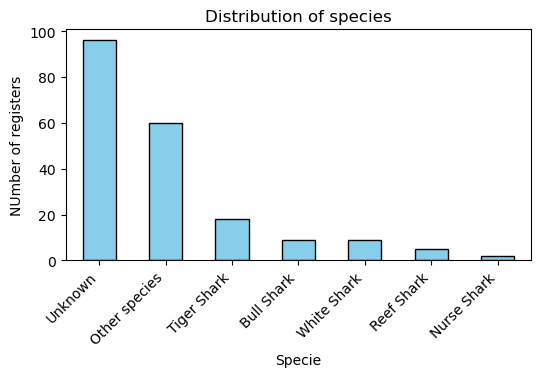

In [11]:
import matplotlib.pyplot as plt

counts = df['species'].value_counts() # Frequency by category

counts.plot(kind='bar', figsize=(6,3), color='skyblue', edgecolor='black') # Bar Graphic

plt.title("Distribution of species")
plt.xlabel("Specie")
plt.ylabel("NUmber of registers")
plt.xticks(rotation=45, ha='right')
plt.show()

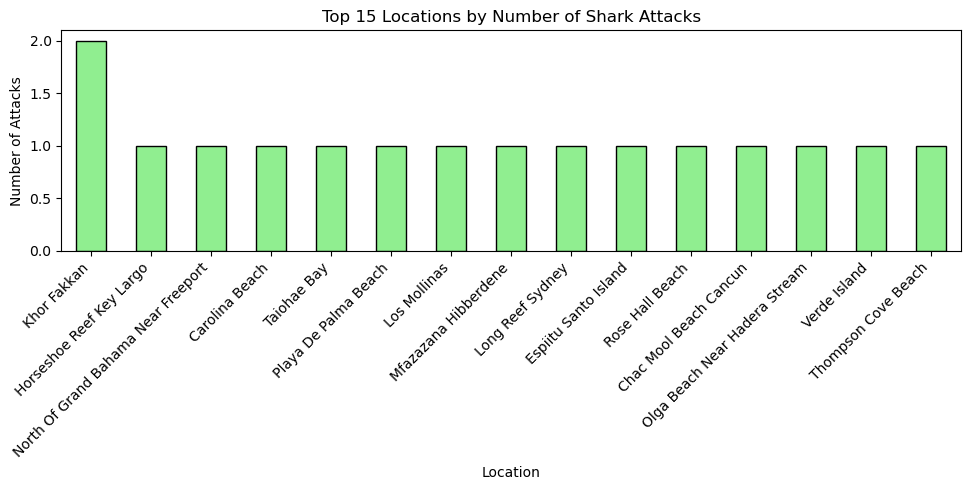

In [12]:
counts_location = df['location'].value_counts().head(15)

counts_location.plot(kind='bar', figsize=(10,5), color='lightgreen', edgecolor='black')

plt.title("Top 15 Locations by Number of Shark Attacks")
plt.xlabel("Location")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

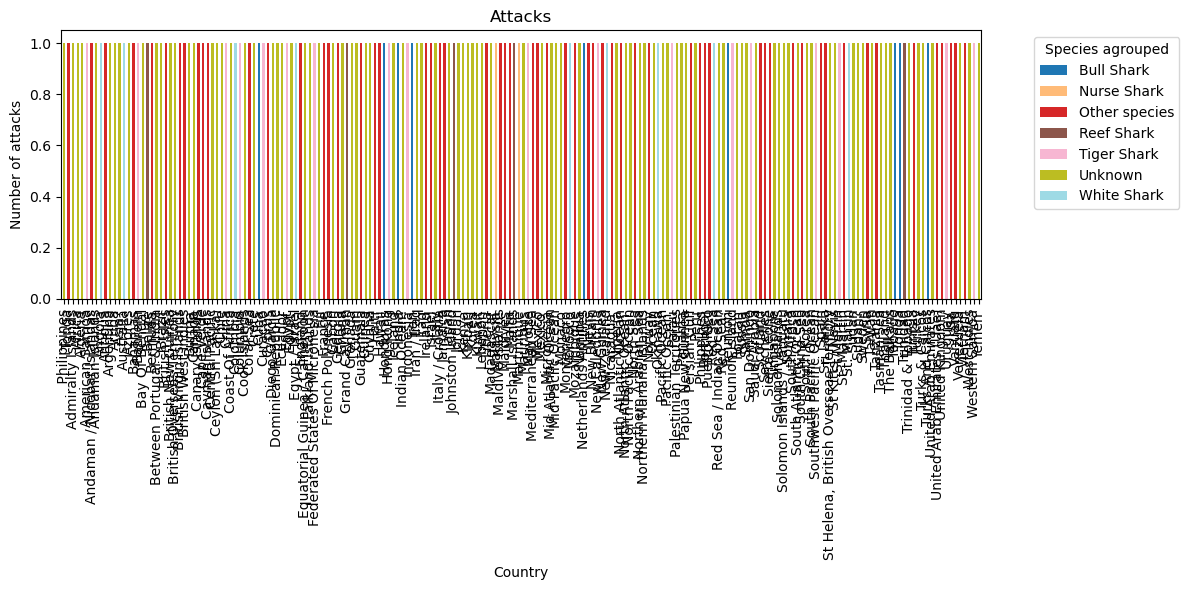

In [13]:
df.groupby('country')['species'].value_counts().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='tab20'
)

plt.title("Attacks")
plt.xlabel("Country")
plt.ylabel("Number of attacks")
plt.legend(title="Species agrouped", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
import folium

# Center map roughly on the equator
m = folium.Map(location=[0, 0], zoom_start=2)

countries = ['Australia', 'Undetermined', 'Bahamas', 'Puerto Rico',
       'French Polynesia', 'Spain', 'Canary Islands', 'South Africa',
       'Vanuatu', 'Jamaica', 'Israel', 'Mexico', 'Maldives',
       'Philippines', 'Mozambique', 'New Caledonia', 'Egypt', 'Thailand',
       'New Zealand', 'USA', 'Honduras', 'Indonesia', 'Morocco', 'Belize',
       'Trinidad and Tobago', 'India', 'Portugal', 'Samoa', 'Colombia',
       'Ecuador', 'Cuba', 'Brazil', 'Seychelles', 'Argentina', 'Fiji',
       'United Kingdom', 'Japan', 'Costa Rica',
       'British Overseas Territory', 'Canada', 'Jordan',
       'Saint Kitts and Nevis', 'Saint Martin', 'Papua New Guinea',
       'Reunion Island', 'China', 'Ireland', 'Italy', 'Malaysia', 'Libya',
       'Mauritius', 'Solomon Islands', 'United Arab Emirates',
       'Cape Verde', 'Dominican Republic', 'Cayman Islands', 'Aruba',
       'Greece', 'France', 'Kiribati', 'Diego Garcia', 'Taiwan',
       'Palestine', 'Guam', 'Nigeria', 'Tonga', 'Croatia', 'Saudi Arabia',
       'Chile', 'Antigua and Barbuda', 'Kenya', 'Russia',
       'Turks and Caicos', 'Azores', 'South Korea', 'Malta', 'Vietnam',
       'Madagascar', 'Panama', 'Somalia', 'Norway', 'Senegal', 'Yemen',
       'Sierra Leone', 'Liberia', 'Venezuela', 'Sri Lanka', 'Uruguay',
       'Micronesia', 'Tanzania', 'Marshall Islands', 'Hong Kong',
       'El Salvador', 'Angola', 'Montenegro', 'Iran', 'Tunisia',
       'Namibia', 'Palau', 'Grenada', 'Iraq', 'Turkey', 'Singapore',
       'Sudan', 'Nicaragua', 'American Samoa', 'Gabon', 'Mayotte',
       'Martinique', 'Guatemala', 'Netherlands Antilles', 'Curacao',
       'Iceland', 'Barbados', 'Monaco', 'Guyana', 'Haiti', 'Kuwait',
       'Falkland Islands', 'Crete', 'Cyprus', 'Burma', 'Lebanon',
       'Georgia', 'Syria', 'Guinea', 'Andaman Islands', 'Cook Islands',
       'Peru', 'Algeria', 'Ghana', 'Sweden', 'Bahrein']

for country in countries:
    folium.Marker(location=[0, 0], popup=country, icon=folium.Icon(color="red")).add_to(m)

m


ModuleNotFoundError: No module named 'folium'

In [15]:
country_mapping = {"Australia": "Australia", "USA": "USA", "Bahamas": "Bahamas", "Puerto Rico": "Puerto Rico", "French Polynesia": "French Polynesia", 
                   "Spain": "Spain", "Canary Islands": "Canary Islands", "South Africa": "South Africa", "Vanuatu": "Vanuatu", "Jamaica": "Jamaica",
                  "Israel": "Israel", "Mexico": "Mexico", "Maldives":"Maldives", "Philippines": "Philippines", "Turks and Caicos": "Turks and Caicos", 
                   "Mozambique":"Mozambique", "New Caledonia":"New Caledonia", "Egypt":"Egypt", "Thailand":"Thailand", 'New Zealand':'New Zealand', 
                   "Hawaii":"USA",'Honduras':'Honduras',"Indonesia":"Indonesia", "Morocco":"Morocco","Belize":"Belize",'Maldive Islands':'Maldives',
                   "Tobago":"Trinidad and Tobago",'Dominican Republic':'Dominican Republic','United Arab Emirates':'United Arab Emirates',
                   "India":"India", "Trinidad":"Trinidad and Tobago",'Coral Sea':"Australia",'Portugal':'Portugal','Samoa':'Samoa','Colombia':'Colombia',
                   'Ecuador':'Ecuador','Cuba':'Cuba','Brazil':'Brazil','Seychelles':'Seychelles','Argentina':'Argentina','Fiji':'Fiji','England':'United Kingdom',
                   'Japan':'Japan','Columbia':'Colombia','British Overseas Territory':'British Overseas Territory','Canada':'Canada','Jordan':'Jordan',
                   'St Kitts / Nevis':"Saint Kitts and Nevis",'St Martin':"Saint Martin",'Papua New Guinea':'Papua New Guinea','China':'China',
                   'Ireland':'Ireland','Montenegro':'Montenegro','Italy':'Italy','Costa Rica':'Costa Rica','Malaysia':'Malaysia','Mauritius':'Mauritius',
                   'St Helena, British Overseas Territory':'British Overseas Territory','United Kingdom':'United Kingdom','St. Martin':"Saint Martin",
                   'France':'France','Trinidad & Tobago':'Trinidad and Tobago','United Arab Emirates (Uae)':'United Arab Emirates','Taiwan':'Taiwan',
                   'Scotland':'United Kingdom','Norway':'Norway','Grand Cayman':'Cayman Islands','Cayman Islands':'Cayman Islands',
                   'Reunion Island':'Reunion Island','Solomon Islands':'Solomon Islands','Reunion':'Reunion Island','Cape Verde':'Cape Verde','Aruba':
                   'Aruba','Kiribati':'Kiribati','Diego Garcia':'Diego Garcia','Palestinian Territories':'Palestine','Guam':'Guam','Nigeria':'Nigeria',
                   'Tonga':'Tonga','Saudi Arabia':'Saudi Arabia','Chile':'Chile','Antigua':'Antigua and Barbuda','Kenya':'Kenya','Russia':'Russia',
                   'Turks & Caicos':'Turks and Caicos','Azores':'Azores','South Korea':'South Korea','Malta':'Malta','Vietnam':'Vietnam','Madagascar':'Madagascar',
                   'Panama':'Panama','Somalia':'Somalia','Nevis':'Saint Kitts and Nevis','Croatia':'Croatia','British Virgin Islands':'British Overseas Territory',
                   'Sierra Leone':'Sierra Leone','St. Maartin':'Saint Martin','Liberia':'Liberia','Mexico ':'Mexico','Venezuela':'Venezuela',
                   'Sri Lanka':'Sri Lanka',' Tonga':'Tonga','Uruguay':'Uruguay','Micronesia':'Micronesia','Okinawa':'Japan','Tanzania':'Tanzania',
                   'Marshall Islands':'Marshall Islands','Senegal':'Senegal','Egypt / Israel':'Undetermined','Northern Arabian Sea':'Undetermined',
                   'Hong Kong':'Hong Kong','El Salvador':'El Salvador','Caribbean Sea':'Undetermined','Angola':'Angola','Bermuda':'British Overseas Territory',
                   'Iran':'Iran','Greece':'Greece','Tunisia':'Tunisia','Namibia':'Namibia','North Atlantic Ocean':'Undetermined','South China Sea':'China',
                   'Palau':'Palau','Western Samoa':'Samoa','Pacific Ocean ':'Undetermined','British Isles':'British Overseas Territory','Grenada':'Grenada',
                   'Iraq':'Iraq','Turkey':'Turkey','Singapore':'Singapore','Sudan':'Sudan','Johnston Island':'USA','New Britain':'USA','South Pacific Ocean':
                   'Undetermined','New Guinea':'Australia','Red Sea':'Undetermined','North Pacific Ocean':'Undetermined','Federated States Of Micronesia':'Micronesia',
                   'Mid Atlantic Ocean':'Undetermined','Admiralty Islands':'Papua New Guinea','British West Indies':'British Overseas Territory',
                   'South Atlantic Ocean':'Undetermined','Solomon Islands / Vanuatu':'Undetermined','Persian Gulf':'Undetermined',
                   'Red Sea / Indian Ocean':'Undetermined', 'Pacific Ocean':'Undetermined', 'North Sea' :'Undetermined','Nicaragua ':'Nicaragua',
                   'American Samoa':'American Samoa','Sudan?':'Sudan','Guatemala':'Guatemala','Martinique':'Martinique','The Balkans':'Undetermined',
                   'Andaman / Nicobar Islandas':'India','Gabon':'Gabon','Mayotte':'Mayotte','Yemen':'Yemen','Bay Of Bengal':'India','North Atlantic Ocean ':
                   'Undetermined','Netherlands Antilles':'Netherlands Antilles','Northern Mariana Islands':'Guam','Iran / Iraq':'Undetermined',
                   ' Philippines':'Philippines','Ceylon (Sri Lanka)':'Sri Lanka','Between Portugal & India':'Undetermined','Central Pacific':'Undetermined',
                   'Indian Ocean':'Undetermined','Southwest Pacific Ocean':'Undetermined','Mid-Pacifc Ocean':'Undetermined','Italy / Croatia':'Undetermined',
                   'Red Sea?':'Undetermined','Korea':'Undetermined','Asia?':'Undetermined','Bahrein':'Bahrein','Curacao':'Curacao','Iceland':'Iceland',
                   'Nicaragua':'Nicaragua','Monaco':'Monaco','Haiti':'Haiti','Kuwait':'Kuwait','Egypt ':'Egypt','Georgia':'Georgia','Syria':'Syria',
                   'Java':'Indonesia','Sweden':'Sweden','Libya':'Libya','Cyprus':'Cyprus','Guyana':'Guyana','Barbados':'Barbados','San Domingo':'Dominican Republic',
                   'Yemen ':'Yemen','Falkland Islands':'Falkland Islands','Crete':'Crete','Burma':'Burma','Lebanon':'Lebanon','British New Guinea':'British Overseas Territory',
                   'Guinea':'Guinea','Andaman Islands':'Andaman Islands','Ceylon':'Sri Lanka','Cook Islands':'Cook Islands','Peru':'Peru','Algeria':'Algeria',
                   'Ghana':'Ghana', 'Roatan':'Honduras',
                   'Tasman Sea':'Undetermined',
                   'Equatorial Guinea / Cameroon':'Undetermined',
                   'Mediterranean Sea':'Undetermined',
                   'Africa':'Undetermined',
                   'Coast Of Africa':'Undetermined',
                   'West Indies':'Undetermined',
                   'Ocean':'Undetermined',
                   'Indian Ocean?':'Undetermined'
                   
                  }
df["country"] = df["country"].map(country_mapping)


df["country"].isna().sum()
df["country"] = df["country"].fillna('Undetermined')
df["country"].isna().sum()

df["country"].unique()
df["country"].nunique()

126